# Projeto 2 - Ciência dos Dados
## Predição do preço de imóveis brasileiros

Nome: Ananda Julia Galvão Campelo

Nome: Carol Magario de Mattos Barretto

Nome: Rafael Dourado Bastos de Oliveira

___
Carregando as bibliotecas necessárias:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os
from scipy import stats, special
import statsmodels.api as sm

# Bibliotecas gráficas para facilitar a vizualização dos dados
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display

# Biblioteca que remove os warnings do Jupter Notbook para uma vizualização mais limpa do documento
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\carol\Downloads\2022.2\Ciência dos Dados\Projeto 2\22-2c-cd-p2-grupo_dj_lovers-1\notebooks


Carregando a base com todos dados:

In [3]:
path = '../data/'
filename = 'houses_to_rent.csv'

data = pd.read_csv(path+filename, sep=",")

* *city*: Cidade onde o imóvel está localizada
* *area*: Area do imovel [m²]
* *rooms*: Número de quartos 
* *bathroom*: Número de banheiros
* *parking spaces*: Número de vagas no estacionamento
* *floor*: Andar em que está localizado
* *animal*: Aceita animais? [acept/not acept]
* *furniture*: Está Mobilhada? [furnished/not furnished]
* *hoa*: Valor do Condominio [R$]
* *rent amount*: Valor do Aluguel [R$]
* *property tax*: IPTU [R$]
* *fire insurance*: Seguro Incendio [R$]
* *total*: Valor Total do Imóvel [R$]


In [4]:
data.head(10)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
5,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,740,1900,85,25,2750
7,São Paulo,213,4,4,4,4,acept,not furnished,2254,3223,1735,41,7253
8,São Paulo,152,2,2,1,3,acept,furnished,1000,15000,250,191,16440
9,Rio de Janeiro,35,1,1,0,2,acept,furnished,590,2300,35,30,2955


____
### Preparando a base de dados

#### Primeira Simplificação

Um estudo rápido dos dados revelou a variavel  `total` é composta da soma das variáveis `hoa`, `rent_amount`, `property_tax` e `fire_insurance`. Por isso, uma simplificação inicial do modelo que tentará descobrir o valor de uma apartamento será utilizar como **variavel Target** o `rent_amount` (valor do aluguel) e descartar as demais variaveis supracitadas durante a analise.

In [5]:
del data['hoa'], data['property_tax'], data['fire_insurance'], data['total']
data.head(10)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
2,Porto Alegre,80,1,1,1,6,acept,not furnished,2800
3,Porto Alegre,51,2,1,0,2,acept,not furnished,1112
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
5,São Paulo,376,3,3,7,-,acept,not furnished,8000
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,1900
7,São Paulo,213,4,4,4,4,acept,not furnished,3223
8,São Paulo,152,2,2,1,3,acept,furnished,15000
9,Rio de Janeiro,35,1,1,0,2,acept,furnished,2300


#### Padronizando os dados

As variaveis `animal` e `furniture` são variaveis qualitativas que possuem apenas dois valores: `possui/aceita` e não `possui/não aceita`. Logo, para padronizar essas variaveis, substituiremos esses valores por `True` e `False`, respectivamente.


In [6]:
data.loc[(data['animal'] == 'acept'), 'animal'] = True
data.loc[(data['animal'] == 'not acept'), 'animal'] = False
data['animal'] = data['animal'].astype('boolean')

data.loc[(data['furniture'] == 'furnished'), 'furniture'] = True
data.loc[(data['furniture'] == 'not furnished'), 'furniture'] = False
data['furniture'] = data['furniture'].astype('boolean')

data.loc[(data['floor'] == '-'), 'floor'] = 0
data['floor'] = data['floor'].astype('int64')

data.head(10)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
0,São Paulo,70,2,1,1,7,True,True,3300
1,São Paulo,320,4,4,0,20,True,False,4960
2,Porto Alegre,80,1,1,1,6,True,False,2800
3,Porto Alegre,51,2,1,0,2,True,False,1112
4,São Paulo,25,1,1,0,1,False,False,800
5,São Paulo,376,3,3,7,0,True,False,8000
6,Rio de Janeiro,72,2,1,0,7,True,False,1900
7,São Paulo,213,4,4,4,4,True,False,3223
8,São Paulo,152,2,2,1,3,True,True,15000
9,Rio de Janeiro,35,1,1,0,2,True,True,2300


### Análise Exploratória

In [7]:
describe = data.describe()
display(describe.round())

,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
count,10692.0,10692.0,10692.0,10692.0,10692.0,10692,10692,10692.0
unique,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,True,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,8316,8086,NaN
mean,149.0,3.0,2.0,2.0,5.0,NaN,NaN,3896.0
std,537.0,1.0,1.0,2.0,5.0,NaN,NaN,3409.0
min,11.0,1.0,1.0,0.0,0.0,NaN,NaN,450.0
25%,56.0,2.0,1.0,0.0,1.0,NaN,NaN,1530.0
50%,90.0,2.0,2.0,1.0,3.0,NaN,NaN,2661.0
75%,182.0,3.0,3.0,2.0,8.0,NaN,NaN,5000.0


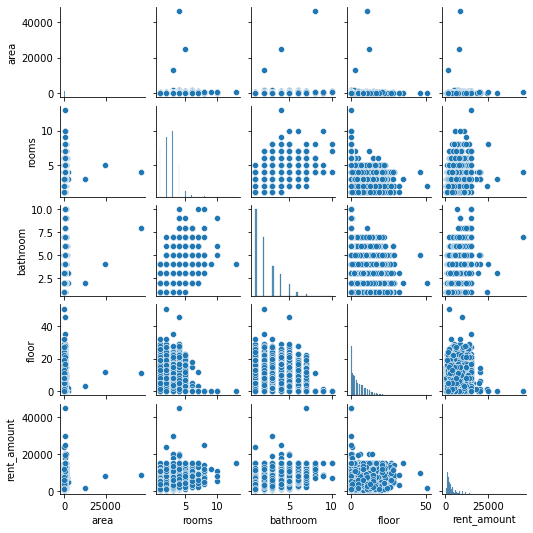

In [8]:
display(sn.pairplot(data[['area', 'rooms', 'bathroom', 'floor', 'rent_amount']], height=1.5))

## Modelo de Predição 
As técnicas de predição escolhidas foram: regressão linear e 

### Divisão da base de dados entre treinamento e teste

In [66]:
train = pd.read_excel(path+'dados.xlsx', sheet_name = 'Treinamento')
test = pd.read_excel(path+'dados.xlsx', sheet_name = 'Teste')

___
## Classificador automático


In [19]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

X = data[['area', 'rooms', 'bathroom', 'floor', 'parking_spaces']]
Y = data['rent_amount']

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1993.
Date:                Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                        08:17:17   Log-Likelihood:                -98618.
No. Observations:               10692   AIC:                         1.972e+05
Df Residuals:                   10686   BIC:                         1.973e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -228.9918     63.211     -3.623      0.000    -352.898    -105.086
area               0.1404      0.045      3.090      0.002       0.051       0.229
rooms            240.1196     30.836      7.787      0.000     179.675     300.564
bathroom        1112.2507     28.164     39.492      0.000    1057.044    1167.457
floor             60.7827      4.478     13.575      0.000      52.006      69.560
parking_spaces   440.1594     21.352     20.615      0.000     398.306     482.012
==============================================================================
Omnibus:                     4127.746   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32368.559
Skew:                           1.649   Prob(JB):                         0.00
Kurtosis:                      10.860   Cond. No.                     1.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

((array([-3.82711688, -3.60288024, -3.47981512, ...,  3.47981512,
          3.60288024,  3.82711688]),
  array([-12585.16545051,  -9370.46121647,  -8314.20926548, ...,
          22246.14084298,  25135.91022968,  34205.17284812])),
 (2345.1949511015227, 2.711506798300955e-12, 0.9377250126059951))

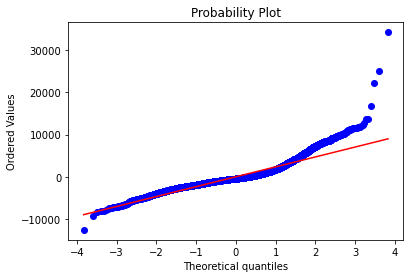

In [10]:
stats.probplot(results.resid, plot=plt, dist=stats.norm)

## Árvore de decisão

In [21]:
!pip install graphviz

In [33]:
# Tabela de treinamento
test

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,Porto Alegre,100,3,1,0,3,acept,furnished,250,1870,59,28,2207
1,São Paulo,998,7,10,4,-,acept,furnished,0,15000,5000,226,20230
2,São Paulo,150,3,3,2,3,acept,not furnished,2177,3700,567,47,6491
3,Rio de Janeiro,60,1,1,1,1,acept,not furnished,650,2165,110,28,2953
4,Porto Alegre,70,2,1,1,2,acept,furnished,100,1360,100,20,1580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,Belo Horizonte,80,2,1,1,3,not acept,not furnished,240,1200,67,16,1523
3204,São Paulo,145,4,3,2,1,acept,not furnished,1644,4800,500,61,7005
3205,São Paulo,260,3,4,4,4,acept,furnished,5000,12000,0,153,17150
3206,Rio de Janeiro,53,1,1,0,2,acept,not furnished,390,1100,14,14,1518


In [67]:
# Separar variáveis explicativas(X) e variável target (y)
X_train =  train[['area','rooms','bathroom','parking spaces','hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']]
y_train = train[['total (R$)']]

In [68]:
# Decision Tree
# importa o regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train) #constroi a árvore

DecisionTreeRegressor(random_state=0)

In [69]:
# Predict no teste
x_test = test[['area','rooms','bathroom','parking spaces','hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']]
y_pred = regressor.predict(x_test)
y_pred

array([ 2184., 20930.,  6492., ..., 20350.,  1496.,  4639.])

In [72]:
# Calcular o RMSE
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y, y_pred, squared=False)
rms**0.5

74.23711661373724

___
## Referências

- https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/
- https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
- https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
- https://medium.com/pursuitnotes/decision-tree-regression-in-6-steps-with-python-1a1c5aa2ee16
- https://stackabuse.com/decision-trees-in-python-with-scikit-learn/